In [3]:
#necessary module
import os ; import sys
sys.path.append(os.getcwd()+"/Equantum")
#path to data
datapath="/scratch/zhaoyuha/Datas/EQuantum_data/topgate/"
setuppath="setup/dotgate/"
from sites import Site
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from fsc import FSC
import scipy.linalg as sl
import scipy.constants as sc
import importlib
import poissonsolver as psolver
import kwant
import scipy.io as sio
%matplotlib widget

from EQsystem import System

In [4]:
import fsc
importlib.reload(fsc)
from fsc import FSC

import EQsystem
importlib.reload(EQsystem)
from EQsystem import System
#test module
import solvers
importlib.reload(solvers)
from solvers import local_solver

import qbuilder
importlib.reload(qbuilder)

from scipy.interpolate import interp1d
from scipy.optimize import brentq

# Simulate dot topgate system

## Define system

In [18]:
def density_function(r):
        spacing0 = 0.005 # spacing at r=0
        k = 1  # spacing increases by 0.05 per unit distance
        return spacing0 + k * r

In [ ]:
geoparams={"lattice_type": "square",   # or honeycomb_lattice, etc.
"box_size": ((-0.5, 0.5), (-0.5, 0.5), (-0.08, 0.08)),
"sampling_density_function": density_function,
"quantum_center": (0,0,0)     # optional, defaults to (0,0,0)
              }

In [ ]:
geoparams={"lattice_type": "honeycomb",   # or honeycomb_lattice, etc.
"box_size": ((-0.5, 0.5), (-0.5, 0.5), (-0.08, 0.08)),
"sampling_density_function": density_function,
"quantum_center": (0,0,0)     # optional, defaults to (0,0,0)
              }

## Initialize System

In [ ]:
syst=System(geoparams)
syst.export_sites(filename=setuppath+"sites.json")

In [ ]:
config_file=setuppath+"0005.json"
syst=System(geoparams,config_file=config_file,ifqsystem=True,quantum_builder="default")

Generated 87891 points in 3D.
Voronoi cells have been created.
1 sites have been removed from the system.


In [12]:
qparams={'Ufunc': lambda x:0,'phi':2.8}
fsc=FSC(syst,ifinitial=False,params=qparams)

The quantum problem has been initialized.


In [13]:
fsc.update_BC(syst,'gate','potential',5)
fsc.update_BC(syst,'backgate','potential',-10,ifinitial=True)

The poisson problem has been initialized.


## Check the Spectrum

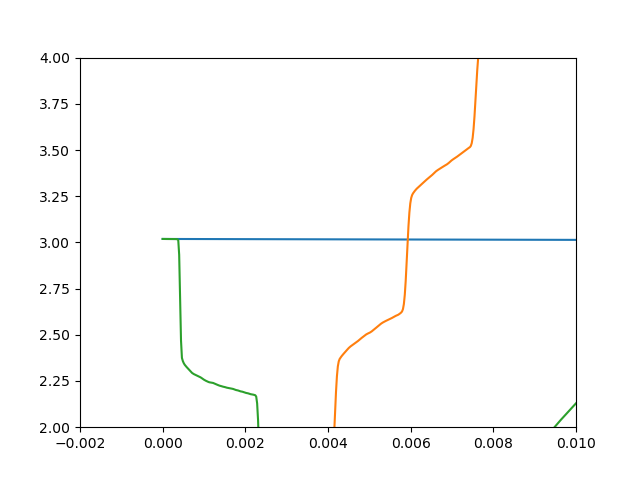

In [40]:
sidx=1557
ni=fsc.ni[fsc.Qprime][sidx]
Ci=fsc.Ci[sidx]
ildos=fsc.ildos[sidx]
Ui=fsc.Ui[fsc.Qprime][sidx]

x_dis=ildos[0]-Ui
y_dis=ildos[1]
ildos_dis=[np.sum(y_dis[:idx]) for idx in range(len(x_dis))]
ildos_dis=ildos_dis
ildos_iterp=interp1d(x_dis,ildos_dis,kind='linear',fill_value='exptrapolate')
def dn_for_Ci(dU):
    return -dU*Ci+ni
def diff(dU):
    return np.abs(dn_for_Ci(dU)-ildos_iterp(dU))

dUs=np.linspace(-5,5,200)*fsc.t
plt.figure()
plt.plot(x_dis,[dn_for_Ci(dU) for dU in x_dis])
plt.plot(x_dis,[ildos_iterp(dU) for dU in x_dis])
plt.plot(x_dis,[diff(dU) for dU in x_dis])
plt.ylim((2,4))
plt.xlim((-0.002,0.01))
#plt.plot(x_dis,ildos_dis)
#plt.plot(fsc.ildos[0][0],fsc.ildos[0][1])
plt.show()

In [13]:
Htest=fsc.qsystem.H.toarray()
pot=np.diagonal(Htest)

In [14]:
ev=np.sort(sl.eigvals(Htest))

In [15]:
ildos=qbuilder.update_ildos(fsc,syst,delta=fsc.t/20,w=np.linspace(-3.9*fsc.t,3.9*fsc.t,2000),
npol_scale=6)

/scratch/zhaoyuha/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


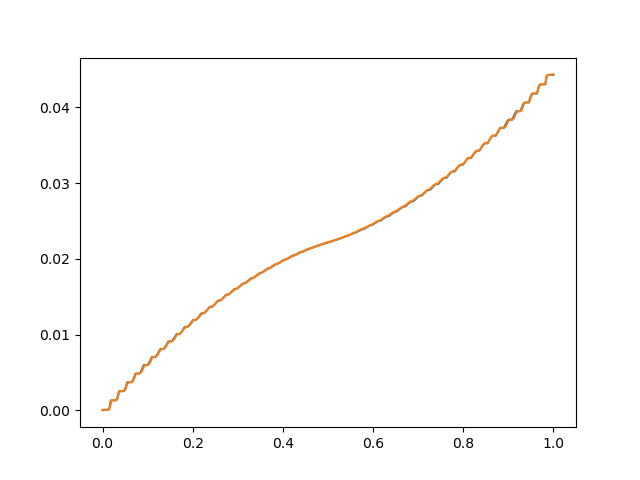

In [21]:
nden=np.array([np.sum(ildos[0][1][:idx])for idx,ee in enumerate(ildos[0][0])])
plt.figure()
plt.plot(np.linspace(0,1,len(ev)),ev+fsc.bandwidth)
plt.plot(nden/nden[-1],ildos[0][0])
plt.show()

## Plot System

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


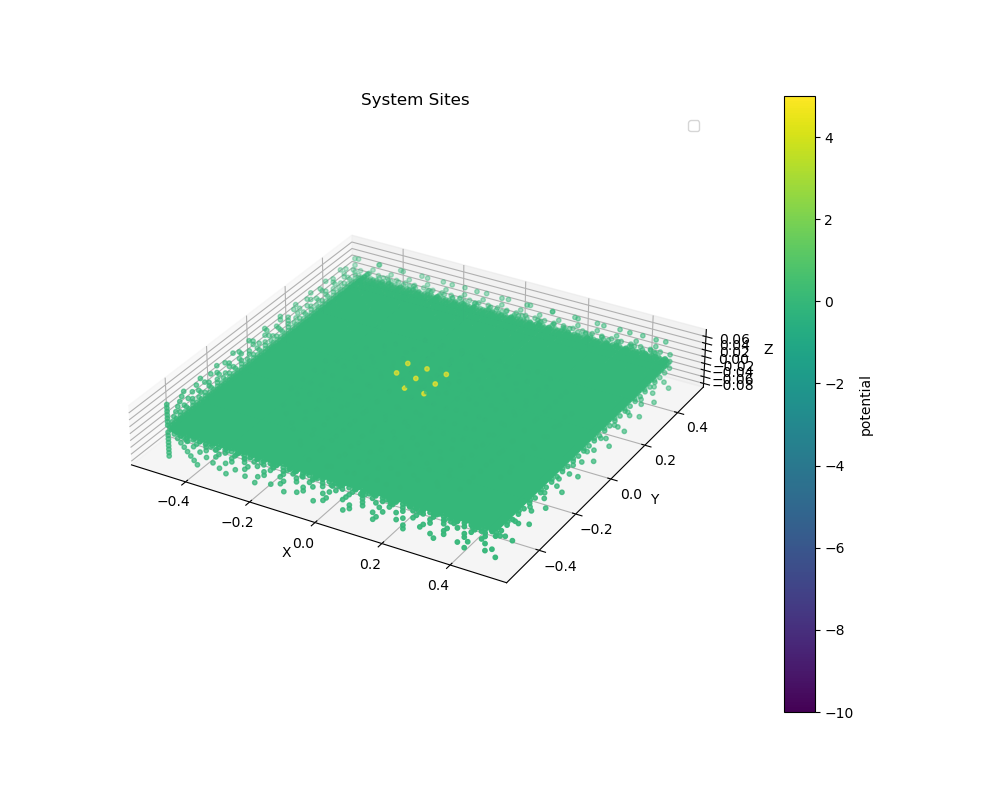

In [92]:
syst.plot_geometry("potential")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


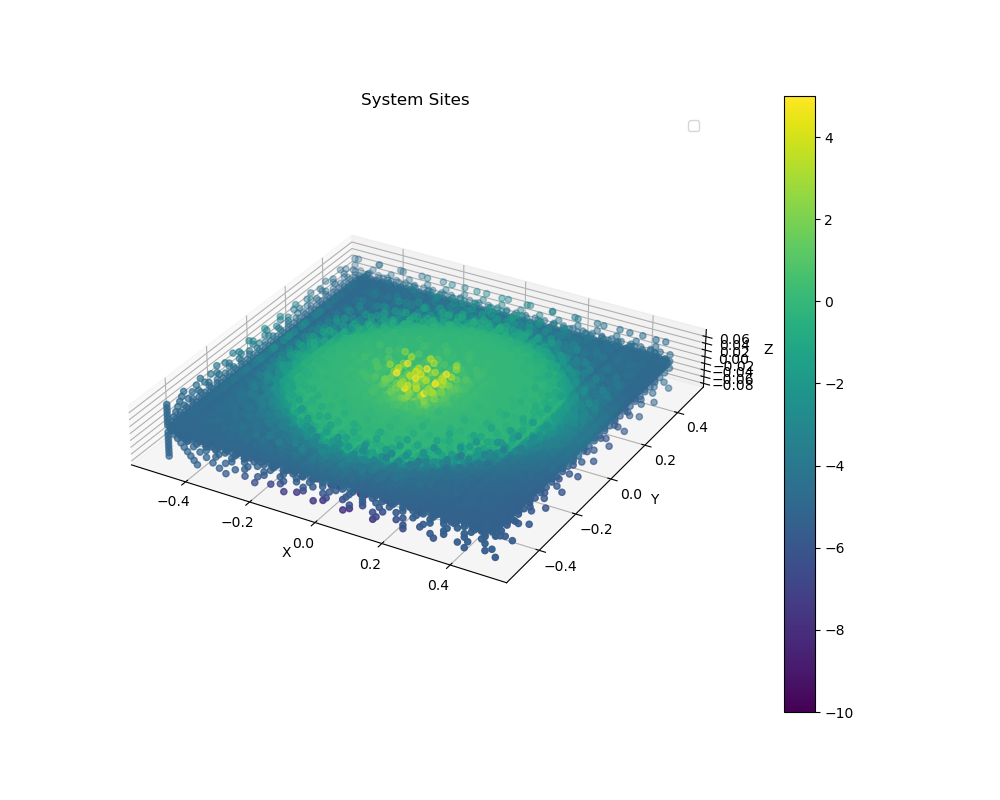

In [30]:
indicate=np.zeros(len(fsc.sites))
indicate[fsc.D_indices]=1
fsc.plot_full(fsc.Ui)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


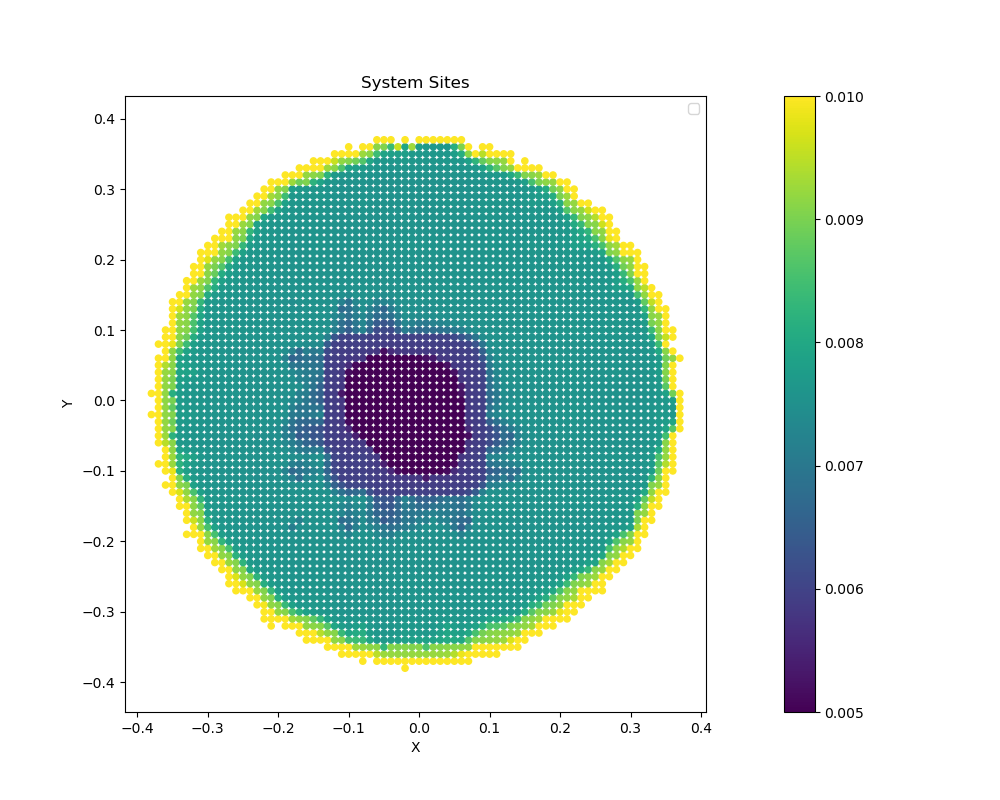

In [49]:
indicate=np.zeros(len(fsc.Qsites))
indicate[1335]=1
plotdata=fsc.Ui[fsc.Qsites]
#plotdata=dUdn[1]
#plotdata=pot
fsc.plot_qsystem(plotdata,vmin=0.005,vmax=0.01)

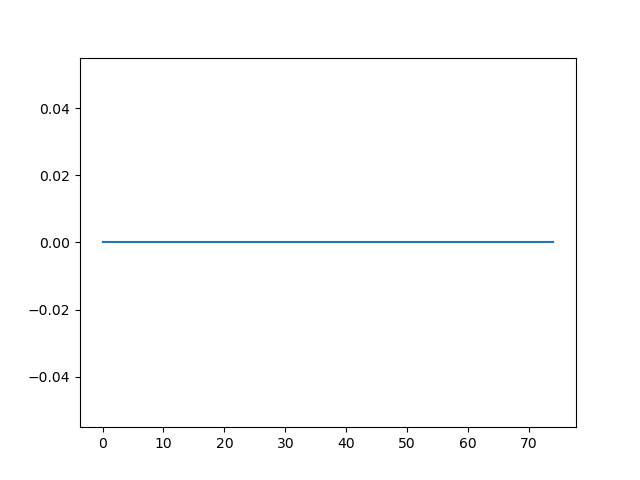

In [16]:
cut_idx=[idx for idx in range(len(fsc.sites)) if np.abs(fsc.sites[idx].coordinates[0])<0.001 and fsc.sites[idx].material=='Qsystem']
plt.figure()
plt.plot(fsc.Ui[cut_idx])
plt.show()

## Solve FSC

In [43]:
fsc.solve(syst,save=datapath+"test")

0.007815675354622484 -0.003653346144263352
1.0478881262512281e-09 -2.904544203151324e-10
The iteration has been conducted for  [0, 0, 0] times.
{'ni_error': [1, 0.0016533784082141667, -0.0007735571583621387], 'Qprime_len': [4419, 4419, 4419], 'ildos_error': [1]}
4.801711657392624e-06 -2.5275081797847926e-06
The iteration has been conducted for  [0, 1, 0] times.
{'ni_error': [1, 0.0016533784082141667, -0.0007735571583621387, -5.351729107076664e-07], 'Qprime_len': [4419, 4419, 4419, 4419], 'ildos_error': [1]}
1.1322495526978125e-08 -6.032389892779321e-09
The iteration has been conducted for  [0, 2, 0] times.
{'ni_error': [1, 0.0016533784082141667, -0.0007735571583621387, -5.351729107076664e-07, -1.2772942470623776e-09], 'Qprime_len': [4419, 4419, 4419, 4419, 4419], 'ildos_error': [1]}
-2.254649625433451e-10 3.326273801667626e-11
The iteration has been conducted for  [0, 3, 0] times.
{'ni_error': [1, 0.0016533784082141667, -0.0007735571583621387, -5.351729107076664e-07, -1.277294247062377

In [14]:
data=sio.loadmat(datapath+"test")
Uis=data['Uis']
nis=data['nis']

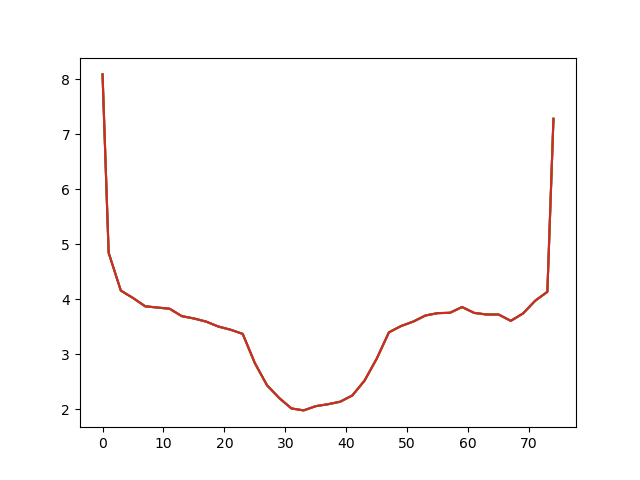

In [17]:
cut_idx=[idx for idx in range(len(fsc.sites)) if np.abs(fsc.sites[idx].coordinates[0])<0.001 and fsc.sites[idx].material=='Qsystem']
plt.figure()
for Uii in nis:
    plt.plot(Uii[cut_idx])
plt.show()